In [1]:
from matplotlib import pyplot
import json
from pathlib import Path

In [2]:
with open("files/results_squadv1.json") as f:
    results = json.load(f)

In [3]:
for k,v in results["checkpoints"].items():
    f1 = v["eval_metrics"]["f1"]
    if f1 > 87:
        model_path = Path(k)
        print(k, f1)
        break

/data_2to/devel_data/nn_pruning/output/squad_test/hp_es-steps_nte20_ls250_est5000_dpm-sigmoied_threshold:1d_alt_apme-sigmoied_threshold_abr32_abc32_it0_fw10_r-l1_rfl5_dtnop-csarron__bert-base-uncased-squad-v1/checkpoint-110000 88.07723643002453


In [15]:
import torch
from matplotlib import pyplot as plt


def graph(model_path, dest_name):
    state_path = model_path / "pytorch_model.bin"
    s = torch.load(state_path)

    sizes = {}

    for k, v in s.items():
        sizes[k] = [int((v != 0).sum()), int(v.numel())]

    from collections import defaultdict
    def ddi():
        return defaultdict(int)

    size_per_layer = defaultdict(ddi)
    ssz0 = 768 * 768

    for k,v in sizes.items():
        try:
            layer_index = int(k.split(".")[3])
        except:
            continue

        if "attention" in k and "weight" in k and "LayerNorm" not in k:
            size_per_layer[layer_index]["attention_nnz"] += v[0]
            size_per_layer[layer_index]["attention_size"] += ssz0

        elif ("intermediate" in k or "output" in k) and "weight" in k and "LayerNorm" not in k:
            size_per_layer[layer_index]["ffn_nnz"] += v[0]
            size_per_layer[layer_index]["ffn_size"] += ssz0 * 4


    x = []
    y_att = []
    y_ffn = []
    y_comparison = []
    overall_nnz = 0
    overall_params = 0

    overall_att_density = 0
    overall_ffn_density = 0
    for k,v in size_per_layer.items():
        x.append(k)
        att_density = v["attention_nnz"] / v["attention_size"]
        ffn_density = v["ffn_nnz"] / v["ffn_size"]
        overall_nnz += v["attention_nnz"]  + v["ffn_nnz"]
        overall_params += v["attention_size"] + v["ffn_size"]
        overall_att_density += att_density
        overall_ffn_density += ffn_density    
        y_att.append(att_density)
        y_ffn.append(ffn_density)
        comparison = v["attention_nnz"] / v["ffn_nnz"]
        y_comparison.append(comparison)


    overall_att_density /= len(x)
    overall_ffn_density /= len(x)
    overall_density = overall_nnz  / overall_params
    print("att density", overall_att_density)   
    print("ffn density", overall_ffn_density)
    print("density", overall_density)
    
    
    fig = pyplot.figure(figsize=(10, 6))
    plt.plot(x, y_att, label="Attention")
    plt.plot(x, y_ffn, label="Feed Forward")
    plt.plot(x, [overall_att_density] * len(x), label="Attention Average")
    plt.plot(x, [overall_ffn_density] * len(x), label="Feed Forward Average")
    plt.plot(x, [overall_density] * len(x), label="Average")
    #plt.plot(x, y_comparison, label = "comparison")
    plt.legend(loc='upper right')
    plt.savefig(dest_name)


att density 0.3265335648148149
ffn density 0.07514105902777779
density 0.15893856095679013
att density 0.06379350026448567
ffn density 0.0909128189086914
density 0.0818730460272895


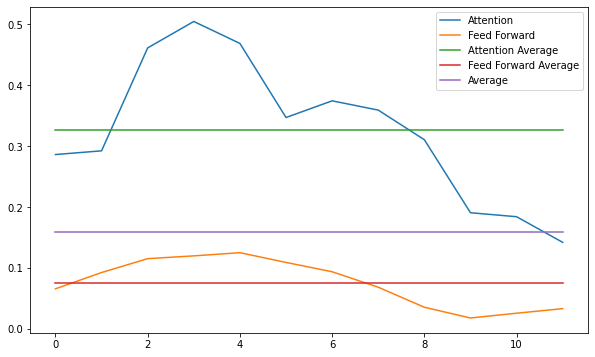

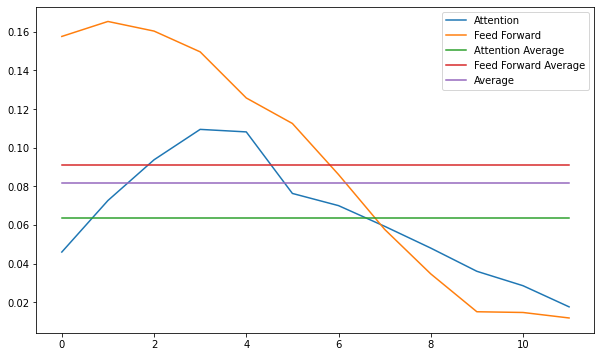

In [16]:

#model_path = "bert-base-uncased-squadv1-x1.96-f88.3-d27-hybrid-filled-opt-v1"

pathes = [("bert-base-uncased-squadv1-x2.32-f86.6-d15-hybrid-v1", "hybrid"),
          ("bert-base-uncased-squadv1-x1.16-f88.1-d8-unstruct-v1", "unstruct")]

for model_path, name in pathes:    
    model_path = Path("../../models/madlag/") / model_path
    dest_name = Path("../../article_nn_pruning/images/") / ("head_pruning_" + name + ".pdf")
    
    graph(model_path, dest_name)

